In [52]:
from huggingface_hub import login

# Log in to Hugging Face
login()

In [2]:
!pip install datasets -q
!pip install peft -q
!pip install trl -q
!pip install -U bitsandbytes -q

In [4]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from datasets import Dataset, load_dataset, DatasetDict
from peft import LoraConfig, PeftModel, get_peft_model, TaskType, prepare_model_for_kbit_training
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from trl import DataCollatorForCompletionOnlyLM, SFTTrainer, SFTConfig

model_name = "microsoft/Phi-3.5-mini-instruct"

## Quantization
**Load the model in 8-bit to fit in the P100 GPU**

so, 3.8B model would take roughly (during inference):

$3,800,000,000 * 1 byte \approx$ **3.8GB**

instead of BF16, that would roughly take (during inference):

$3,800,000,000 * 2 bytes \approx$ **7.6GB**

In [6]:
# Configure for 8-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=5.0, # Lower to save more memory, by converting more params to int8
    llm_int8_skip_modules=None # quantize all modules
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'right'

# Load the model using bitsandbytes with INT8 quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

In [ ]:
import transformers

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    model_kwargs={"torch_dtype": torch.int8},
    device_map="auto",
)

In [20]:
dataset = load_dataset("qiaojin/PubMedQA", "pqa_artificial")
df = dataset['train'].to_pandas()
df.head()

,pubid,question,context,long_answer,final_decision
0,25429730,Are group 2 innate lymphoid cells ( ILC2s ) in...,{'contexts': ['Chronic rhinosinusitis (CRS) is...,"As ILC2s are elevated in patients with CRSwNP,...",yes
1,25433161,Does vagus nerve contribute to the development...,{'contexts': ['Phosphatidylethanolamine N-meth...,Neuronal signals via the hepatic vagus nerve c...,yes
2,25445714,Does psammaplin A induce Sirtuin 1-dependent a...,{'contexts': ['Psammaplin A (PsA) is a natural...,PsA significantly inhibited MCF-7/adr cells pr...,yes
3,25431941,Is methylation of the FGFR2 gene associated wi...,{'contexts': ['This study examined links betwe...,We identified a novel biologically plausible c...,yes
4,25432519,Do tumor-infiltrating immune cell profiles and...,{'contexts': ['Tumor microenvironment immunity...,Breast cancer immune cell subpopulation profil...,yes


In [57]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): Phi3ForCausalLM(
          (model): Phi3Model(
            (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
            (embed_dropout): Dropout(p=0.0, inplace=False)
            (layers): ModuleList(
              (0-31): 32 x Phi3DecoderLayer(
                (self_attn): Phi3Attention(
                  (o_proj): lora.Linear8bitLt(
                    (base_layer): Linear8bitLt(in_features=3072, out_features=3072, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=3072, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=3072, bias=False)
               

Sample 5K rows

In [21]:
print(df.isnull().sum().sum()) # no missing values

# drop pubid column
df.drop('pubid', axis=1, inplace=True)

# Sample 2500 rows for each class
df_yes = df[df['final_decision'] == 'yes'].sample(2500, random_state=42)
df_no = df[df['final_decision'] == 'no'].sample(2500, random_state=42)
df = pd.concat([df_yes, df_no], axis=0)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Reset dataframe index
df.reset_index(drop=True, inplace=True)

df.shape

0


(5000, 4)

Apply chat template to the dataset

In [23]:
def format_row(row: dict, generation_token=False, messages=None):
    prompt = """context:
{context}
Question:
{query}"""
    context = ""
    for i, c in enumerate(row['context']['contexts']):
        context += f"Document {i+1}:\n\"{c}\"\n"
    
    if not messages:
        messages = [
            {"role": "user", "content": prompt.format(context=context, query=row['question'])},
            {"role": "assistant", "content": row['long_answer']}
        ]
    
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_token=generation_token)

def count_tokens(row: dict):
    return len(tokenizer(row['text'], add_special_tokens=False, return_attention_mask=False)['input_ids'])

# Apply template to the dataset
df['text'] = df.apply(format_row, axis=1)

# Add `num_tokens` column
df['num_tokens'] = df.apply(count_tokens, axis=1)

df.head()

,question,context,long_answer,final_decision,text,num_tokens
0,Does 212Pb-radioimmunotherapy potentiate pacli...,{'contexts': ['Paclitaxel has recently been re...,These findings suggest that the sensitisation ...,yes,"<|user|>\ncontext:\nDocument 1:\n""Paclitaxel h...",685
1,Does single-dose etomidate increase mortality ...,{'contexts': ['The effect of single-dose etomi...,Current evidence indicates that single-dose et...,no,"<|user|>\ncontext:\nDocument 1:\n""The effect o...",601
2,Does irrigation of Cutaneous Abscesses Improve...,{'contexts': ['Irrigation of the cutaneous abs...,Although there were baseline differences betwe...,no,"<|user|>\ncontext:\nDocument 1:\n""Irrigation o...",492
3,Do larger inflow angle and incomplete occlusio...,{'contexts': ['Unruptured paraclinoid aneurysm...,Unruptured paraclinoid aneurysms had a high in...,yes,"<|user|>\ncontext:\nDocument 1:\n""Unruptured p...",673
4,Are duodenal ischemia and upper GI bleeding do...,{'contexts': ['Regional chemotherapy is used s...,While technically feasible to treat locally ad...,yes,"<|user|>\ncontext:\nDocument 1:\n""Regional che...",652


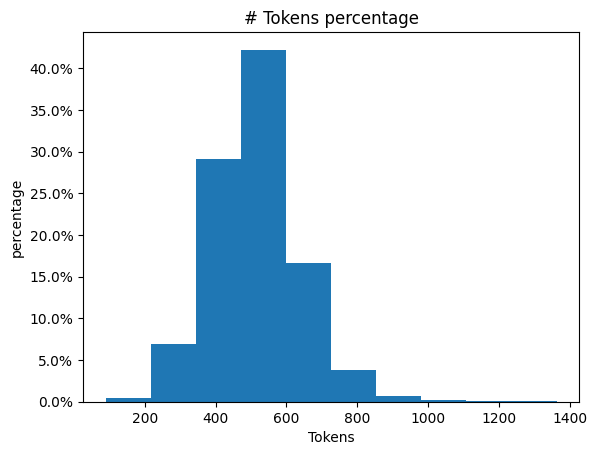

In [24]:
# Plot tokens number
plt.hist(df.num_tokens, weights=np.ones(len(df.num_tokens)) / len(df.num_tokens))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('# Tokens percentage')
plt.xlabel('Tokens')
plt.ylabel('percentage')
plt.show()

In [25]:
# Removve rows with tokens more than 700
df = df[df.num_tokens < 700].reset_index(drop=True)
df

,question,context,long_answer,final_decision,text,num_tokens
0,Does 212Pb-radioimmunotherapy potentiate pacli...,{'contexts': ['Paclitaxel has recently been re...,These findings suggest that the sensitisation ...,yes,"<|user|>\ncontext:\nDocument 1:\n""Paclitaxel h...",685
1,Does single-dose etomidate increase mortality ...,{'contexts': ['The effect of single-dose etomi...,Current evidence indicates that single-dose et...,no,"<|user|>\ncontext:\nDocument 1:\n""The effect o...",601
2,Does irrigation of Cutaneous Abscesses Improve...,{'contexts': ['Irrigation of the cutaneous abs...,Although there were baseline differences betwe...,no,"<|user|>\ncontext:\nDocument 1:\n""Irrigation o...",492
3,Do larger inflow angle and incomplete occlusio...,{'contexts': ['Unruptured paraclinoid aneurysm...,Unruptured paraclinoid aneurysms had a high in...,yes,"<|user|>\ncontext:\nDocument 1:\n""Unruptured p...",673
4,Are duodenal ischemia and upper GI bleeding do...,{'contexts': ['Regional chemotherapy is used s...,While technically feasible to treat locally ad...,yes,"<|user|>\ncontext:\nDocument 1:\n""Regional che...",652
...,...,...,...,...,...,...
4676,Is helicobacter pylori-induced damage to the g...,{'contexts': ['An increase in the prevalence o...,This study lends no support to theories of inc...,no,"<|user|>\ncontext:\nDocument 1:\n""An increase ...",583
4677,Is expanded HIV testing coverage associated wi...,{'contexts': ['Expanded HIV testing coverage c...,Increases in recent HIV testing coverage may h...,yes,"<|user|>\ncontext:\nDocument 1:\n""Expanded HIV...",507
4678,Do variations in C-reactive protein during a s...,{'contexts': ['An increase in C-reactive prote...,CRP changes during a single HD session do not ...,no,"<|user|>\ncontext:\nDocument 1:\n""An increase ...",530
4679,Do potassium and Magnesium Supplementation Pro...,{'contexts': ['Despite a lack of demonstrated ...,Higher serum potassium and magnesium levels we...,no,"<|user|>\ncontext:\nDocument 1:\n""Despite a la...",577


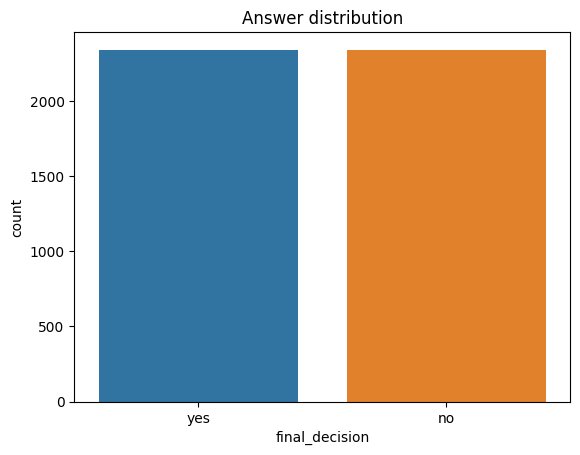

In [26]:
sns.countplot(data=df, x='final_decision', order=['yes', 'no'])
plt.title('Answer distribution')
plt.show()

In [27]:
print(df.text.iloc[0])

<|user|>
context:
Document 1:
"Paclitaxel has recently been reported by this laboratory to potentiate the high-LET radiation therapeutic (212)Pb-TCMC-trastuzumab, which targets HER2. To elucidate mechanisms associated with this therapy, targeted α-particle radiation therapeutic (212)Pb-TCMC-trastuzumab together with paclitaxel was investigated for the treatment of disseminated peritoneal cancers."
Document 2:
"Mice bearing human colon cancer LS-174T intraperitoneal xenografts were pre-treated with paclitaxel, followed by treatment with (212)Pb-TCMC-trastuzumab and compared with groups treated with paclitaxel alone, (212)Pb-TCMC-HuIgG, (212)Pb-TCMC-trastuzumab and (212)Pb-TCMC-HuIgG after paclitaxel pre-treatment."
Document 3:
"(212)Pb-TCMC-trastuzumab with paclitaxel given 24 h earlier induced increased mitotic catastrophe and apoptosis. The combined modality of paclitaxel and (212)Pb-TCMC-trastuzumab markedly reduced DNA content in the S-phase of the cell cycle with a concomitant incr

In [28]:
# Split data
train, test = train_test_split(df, test_size=0.2, random_state=0)
val, test = train_test_split(test, test_size=0.2, random_state=0)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

len(train), len(val), len(test)

(3744, 749, 188)

In [29]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'validation': Dataset.from_pandas(val),
    'test': Dataset.from_pandas(test)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'long_answer', 'final_decision', 'text', 'num_tokens'],
        num_rows: 3744
    })
    validation: Dataset({
        features: ['question', 'context', 'long_answer', 'final_decision', 'text', 'num_tokens'],
        num_rows: 749
    })
    test: Dataset({
        features: ['question', 'context', 'long_answer', 'final_decision', 'text', 'num_tokens'],
        num_rows: 188
    })
})

# Test original model with few-shot prompt

In [39]:
prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Use the following examples as reference for the ideal answer style.

Example 1:

context:

document 1:
"Aspirin is commonly used to reduce fever, pain, and inflammation. It works by inhibiting the production of prostaglandins. However, it should be used with caution in patients with peptic ulcer disease due to the risk of gastrointestinal bleeding."

Document 2:
"Patients with a history of peptic ulcers are at an increased risk of complications when using nonsteroidal anti-inflammatory drugs (NSAIDs) like aspirin. Alternatives such as acetaminophen are often recommended in these cases to minimize risks."

Question:
Can aspirin be recommended for a patient with a history of peptic ulcers?"Aspirin is commonly used to reduce fever, pain, and inflammation. It works by inhibiting the production of prostaglandins. However, it should be used with caution in patients with peptic ulcer disease due to the risk of gastrointestinal bleeding."

Document 2:
"Patients with a history of peptic ulcers are at an increased risk of complications when using nonsteroidal anti-inflammatory drugs (NSAIDs) like aspirin. Alternatives such as acetaminophen are often recommended in these cases to minimize risks."

Question:
Can aspirin be recommended for a patient with a history of peptic ulcers?

Answer:
Aspirin should be used with caution in patients with a history of peptic ulcers due to the increased risk of gastrointestinal bleeding. In such cases, it is generally recommended to use alternatives like acetaminophen to manage pain and inflammation, which have a lower risk of causing such complications.

Example 2:

context:

document 1:
"Metformin is the first-line treatment for type 2 diabetes, helping to lower blood sugar levels by decreasing glucose production in the liver and improving insulin sensitivity."

Document 2:
"Patients with chronic kidney disease (CKD) need careful monitoring while taking metformin, as the drug is excreted by the kidneys. Accumulation of metformin can lead to lactic acidosis, a rare but serious complication."

Question:
Is metformin safe for patients with chronic kidney disease?

Answer:
Metformin can be used in patients with chronic kidney disease, but it requires careful monitoring of kidney function. In advanced stages of CKD, metformin may need to be reduced or discontinued due to the risk of lactic acidosis. It is important to assess the patient’s kidney function before prescribing metformin.

Example 3:

context:

document 1:
"Hypertension is a major risk factor for cardiovascular diseases. ACE inhibitors, such as lisinopril, are commonly prescribed to manage hypertension and reduce the risk of heart attacks and strokes."

Document 2:
"Recent studies have shown that ACE inhibitors also have a protective effect on the kidneys in patients with diabetes. They reduce proteinuria and slow the progression of diabetic nephropathy."

Document 3:
"However, ACE inhibitors should be used cautiously in patients with renal artery stenosis or in those with a history of angioedema, as they may exacerbate these conditions."

Question:
What are the benefits and risks of using ACE inhibitors in patients with diabetes?

Answer:
ACE inhibitors, such as lisinopril, provide multiple benefits for patients with diabetes. They help manage hypertension and reduce cardiovascular risks, while also offering kidney protection by reducing proteinuria and slowing the progression of diabetic nephropathy. However, they should be used with caution in patients with renal artery stenosis or a history of angioedema, as these conditions could be worsened by ACE inhibitors. Regular monitoring is recommended to balance the benefits and risks.

###

Now your turn:

context:

{context}

Question:
{query}

Answer:"""

context = ""
for i, c in enumerate(dataset['test']['context'][50]['contexts']):
    context += f"Document {i+1}:\n\"{c}\"\n"

messages = [
    {"role": "system", "content": "You are a helpful medical assistant that answers questions based on retrieved medical literature."},
    {"role": "user", "content": prompt.format(context=context, query=dataset['test']['question'][50])},
]

print(f"Question: {dataset['test']['question'][50]}\n\n\nAnswer: {dataset['test']['long_answer'][50]} Short Answer: {dataset['test']['final_decision'][50]}\n\nllm answer: {pipeline(messages, max_new_tokens=512)[0]['generated_text'][-1]['content']}")

Question: Is expression of the apoptosis suppressing protein bcl-2 in prostatic adenocarcinoma related to tumor malignancy?


Answer: The expression of bcl-2 protein in prostatic adenocarcinoma is related to tumor malignancy, but the prognostic significance of the expression requires further analyses, particularly in localized tumors. Short Answer: yes

llm answer:  The expression of the apoptosis suppressing protein bcl-2 in prostatic adenocarcinoma is positively correlated to high T-category, metastatic disease, and poor histological differentiation of the tumor, which are indicators of tumor malignancy. However, in multivariate analysis, the expression of bcl-2 had no independent prognostic value. This suggests that while bcl-2 expression is associated with more aggressive tumor features, it does not independently predict the prognosis. Therefore, bcl-2 expression is related to tumor malignancy but is not a standalone prognostic marker.




**Even with providing context and using few-shot prompting, the model still couldn't answer the question.**

# LoRA Fine-tuning

In [40]:
# print the model architecture to see which layers should be affected
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear8bitLt(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear8bitLt(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear8bitLt(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear8bitLt(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm):

In [46]:
response_template = "<|end|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

lora_config = LoraConfig(
    r=8,
    lora_alpha=8, # small change (like a learning rate)
    target_modules=[
        "self_attn.o_proj",
        "self_attn.qkv_proj",
    ],
    lora_dropout=0.1,
    bias='none', # No Bias
    task_type=TaskType.CAUSAL_LM
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 4,718,592 || all params: 3,825,798,144 || trainable%: 0.1233


In [47]:
sft_config = SFTConfig(
    output_dir='/kaggle/working/model',
    dataset_text_field="text",
    max_seq_length=700,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=5,
    learning_rate=1e-4,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False
    },
    report_to="none",
    load_best_model_at_end=True,
    seed=0,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    data_collator=collator
)

Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/749 [00:00<?, ? examples/s]

In [48]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cp

Step,Training Loss,Validation Loss
94,0.000000,nan
188,0.000000,nan
282,0.000000,nan
376,0.000000,nan


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantizati

TrainOutput(global_step=468, training_loss=0.0, metrics={'train_runtime': 19009.101, 'train_samples_per_second': 0.394, 'train_steps_per_second': 0.025, 'total_flos': 9.979463441048371e+16, 'train_loss': 0.0, 'epoch': 2.0})

In [58]:
# Push the model to Hugging Face Hub after training
model.push_to_hub("oyounis/Phi-3.5-instruct-pubmedQA")
tokenizer.push_to_hub("oyounis/Phi-3.5-instruct-pubmedQA")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/oyounis/Phi-3.5-instruct-pubmedQA/commit/2a36ec6656a220832d4ce4af431785410e4aff8f', commit_message='Upload tokenizer', commit_description='', oid='2a36ec6656a220832d4ce4af431785410e4aff8f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oyounis/Phi-3.5-instruct-pubmedQA', endpoint='https://huggingface.co', repo_type='model', repo_id='oyounis/Phi-3.5-instruct-pubmedQA'), pr_revision=None, pr_num=None)

In [51]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): Phi3ForCausalLM(
          (model): Phi3Model(
            (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
            (embed_dropout): Dropout(p=0.0, inplace=False)
            (layers): ModuleList(
              (0-31): 32 x Phi3DecoderLayer(
                (self_attn): Phi3Attention(
                  (o_proj): lora.Linear8bitLt(
                    (base_layer): Linear8bitLt(in_features=3072, out_features=3072, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=3072, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=3072, bias=False)
               